In [2]:
import psutil
import sys
import tracemalloc
import linecache

In [4]:
tracemalloc.start()

In [1]:
import os

os.environ[
    "OMP_NUM_THREADS"
] = "64"  # for jupyter.nersc.gov otherwise the notebook only uses 2 cores

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

sns.set_context("talk")
# sns.set()
sns.set_style("ticks")

import matplotlib as mpl
mpl.rc('image', cmap='coolwarm')

import numpy as np
import healpy as hp

import logging
log = logging.getLogger("healpy")
log.setLevel(logging.ERROR)

import time 

from ForSEplus.my_forse_class import forse_my
from ForSEplus.utility import rescale_input, correct_EB, from_12toXX
from ForSEplus.recompose_class import recom
from ForSEplus.after_training_12amin import post_training as post_training_12
from ForSEplus.after_training_3amin import post_training as post_training_3

import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
for g in range(len(physical_devices)):
    tf.config.experimental.set_memory_growth(physical_devices[g], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import importlib
import ForSEplus
import sys

In [3]:
# TODO 
# change path to some environment variable like os.environ['Forse_plus_data']
# change verbose to log
# recompose to full sky 12amin
# treate Q and U separately!!!
# change float6 to float32!!
# correct_EB also consumes a lo of memory

In [5]:
def gen_ForSE(dir_data = '/pscratch/sd/j/jianyao/ForSE_plus_data/', 
              save_dir = '/pscratch/sd/j/jianyao/forse_output/Random_training_files/FIX_MF/Complete/', 
              Nsam = 1, 
              recom_12 = False,
              save_12 = False, 
              return_3 = True, 
              verbose = False):
    
    '''
    Parameters
    ----------
    
    dir_data: Str; Path of ForSE_plus_data which includes all the ancillary data;
    Nsam: Int; Number of realizations to generate;
    save_dir: Str or None; path to save the generated maps; If None, do not save maps to disk.
    save_12: Bool; If True, full-sky maps at 12 arcmin will also be saved;
    return_3: Bool; If True, full-sky maps at 3 arcmin will returned as the output of the function. Otherwise maps will be saved into `save_dir`;
    
    Return
    ------
    None or list of arrays.
    
    '''
    
    ss_I = np.load(dir_data + 'maps_cls/GNILC_Thr12_Qlr80_20x20deg_Npix320_full_sky_adaptive.npy', allow_pickle=True)[0, 0:348]

    Ls_Q80amin = np.load(dir_data + 'maps_cls/GNILC_Thr12_Qlr80_20x20deg_Npix320_full_sky_adaptive.npy', allow_pickle=True)[1, 0:174]*1e6
    Ls_U80amin = np.load(dir_data + 'maps_cls/GNILC_Thr12_Ulr80_20x20deg_Npix320_full_sky_adaptive.npy', allow_pickle=True)[1, 0:174]*1e6

    gauss_ss_ps_12 = np.load(dir_data + 'maps_cls/gauss_small_scales_12_over_80_power_spectra.npy') #[2, 174, 49, 1, 25] Q, U
    gauss_ss_mean_std_12 = np.load(dir_data + 'maps_cls/gauss_small_scales_12_over_80_mean_and_std.npy') #[4, 174, 49] Q_mean, Q_std, U_mean, U_std

    gauss_ss_ps_3 = np.load(dir_data + 'maps_cls/gauss_small_scales_3_over_20_power_spectra_lmax_3500.npy') #[2, 174, 49, 1, 25] Q, U
    gauss_ss_mean_std_3 = np.load(dir_data + 'maps_cls/gauss_small_scales_3_over_20_mean_and_std.npy') #[4, 174, 49] Q_mean, Q_std, U_mean, U_std

    Ls_Q = np.load(dir_data + 'maps_cls/GNILC_Thr12_Qlr80_20x20deg_Npix320_full_sky_adaptive.npy')[1, 0:174]
    Ls_U = np.load(dir_data + 'maps_cls/GNILC_Thr12_Ulr80_20x20deg_Npix320_full_sky_adaptive.npy')[1, 0:174]

    # data 3.0G
    model_Q_12amin = dir_data + 'models/model_all_h5_snr_1_Q11'
    model_U_12amin = dir_data + 'models/model_all_h5_snr_1_U12'

    model_Q_3amin =  dir_data + 'models/model_3amin_696_patches_Q85'
    model_U_3amin =  dir_data + 'models/model_3amin_696_patches_U396'
    
    # model 1.0 G
    start = time.time()
    print('Loading models')
    model_Q = tf.keras.models.load_model(model_Q_12amin, compile = False)
    model_U = tf.keras.models.load_model(model_U_12amin, compile = False)

    model_Q_3 = tf.keras.models.load_model(model_Q_3amin, compile = False)
    model_U_3 = tf.keras.models.load_model(model_U_3amin, compile = False)

    print('Initialize the recomposing class')
    # recom class: 8G 
    recom_3 = recom(npix = 1280, pixelsize = 0.937, overlap = 2, nside = 4096, 
                     apodization_file = dir_data + 'masks/mask_1280x1280.npy', 
                     xy_inds_file = dir_data + 'geometry/recompose_xinds_yinds_4096', 
                     index_sphere_file = dir_data + 'geometry/recompose_footprint_healpix_index_4096', verbose=False)
    
    if recom_12 == True:
        recom_12 = recom(npix = 320, pixelsize = 3.75, overlap = 2, nside = 2048, 
                         apodization_file = dir_data + 'masks/mask_320x320.npy', 
                         xy_inds_file = dir_data + 'geometry/recompose_xinds_yinds_2048', 
                         index_sphere_file = dir_data + 'geometry/recompose_footprint_healpix_index_2048', verbose=False)

    print('Load maps at 80amin')

    print('Generating input random noise with model SNR = %s...'%1)
    # np.random.seed(2048)

    output12 = post_training_12(ss_I, Ls_Q80amin, Ls_U80amin, MF = False)
    output3 = post_training_3(ss_I, MF = False)
    
    if return_3:
        maps_all = []
        
    for i in range(Nsam):

        if verbose == True:
            print('12amin Generating patches...')

        if verbose == True:
            print('12amin: Renormalize patches...')
            
        output12.import_NNout(model_Q.predict(rescale_input([Ls_Q], random_noise = [np.random.uniform(-1, 1, (174, 320, 320))])), stokes = 'Q')
        # .astype(np.float32)
        output12.import_NNout(model_U.predict(rescale_input([Ls_U], random_noise = [np.random.uniform(-1, 1, (174, 320, 320))])), stokes = 'U')
            
        save_dir_12 = save_dir + '12amin_norm/'
        norm_Q12amin = 'NN_out_Q_12amin_from_12amin_physical_units_20x20_320_%03d.npy'%(i)
        norm_U12amin = 'NN_out_U_12amin_from_12amin_physical_units_20x20_320_%03d.npy'%(i)
        output12.normalization(gauss_ss_ps_12, gauss_ss_mean_std_12, mask_path = dir_data + 'masks/mask_320x320.npy')
                               # save_path = [save_dir_12 + norm_Q12amin, save_dir_12 + norm_U12amin])            

        # del output12

        if recom_12 == True:
            full_Q_12 = recom_12.recompose_fast(output12.NNmapQ_corr)
            full_U_12 = recom_12.recompose_fast(output12.NNmapU_corr) 

        # output12.plot_MF()
            # dir_12 = '/pscratch/sd/j/jianyao/forse_output/Random_training_files/FIX_MF/2_random_12amin_renormalized/New_realizations_1/'
            # NNmapQ_corr = np.load(dir_12 + 'Random_1_testing_data_Nico_T12amin_1_Q80amin_renormalized_000.npy')
            # NNmapU_corr = np.load(dir_12 + 'Random_1_testing_data_Nico_T12amin_1_U80amin_renormalized_000.npy')

        if verbose == True:
            print('3amin: construct input 20amin and normalizing-13amin maps')

        if verbose == True:
            print('3amin: Generating patches...')

        # 6.5G # 6.5G
        output3.import_NNout(model_Q_3.predict(rescale_input([from_12toXX(output12.NNmapQ_corr, XX = 20)], random_noise = [np.random.uniform(-1, 1, (174*49, 320, 320))])), stokes = 'Q')
        output3.import_NNout(model_U_3.predict(rescale_input([from_12toXX(output12.NNmapU_corr, XX = 20)], random_noise = [np.random.uniform(-1, 1, (174*49, 320, 320))])), stokes = 'U')

        if verbose == True:
            print('3amin: renormalize patches ...')
        
        output3.normalization(gauss_ss_ps_3, gauss_ss_mean_std_3, output12.NNmapQ_corr, output12.NNmapU_corr, 
                              mask_path = dir_data + 'masks/mask_320x320.npy')

        norm_Q3amin = 'NN_out_Q_3amin_from_20amin_physical_units_20x20_1280_%03d.npy'%(i)
        norm_U3amin = 'NN_out_U_3amin_from_20amin_physical_units_20x20_1280_%03d.npy'%(i)
        save_dir_3 = '/pscratch/sd/j/jianyao/forse_output/Random_training_files/FIX_MF/Complete/3amin_norm/'
        output3.combine_to_20by20(output3.NNmapQ_corr, output3.NNmapU_corr, maps = 'ss_norm')
        # output3.combine_to_20by20(NNout_Q.reshape(174,49,320,320), NNout_U.reshape(174,49,320,320), maps = 'ss')
        # test = output3.plot_MF(patch_N = 3, savedir=False)

        if verbose == True:
            print('3amin: reproject to full sky ...')
        full_Q = recom_3.recompose_fast(output3.NN_20by20_Q_norm)
        full_U = recom_3.recompose_fast(output3.NN_20by20_U_norm) 

        if return_3:
            # maps_all.append(correct_EB(full_Q, full_U))
            maps_all.append([full_Q, full_U])
        
        else:
            # maps_3amin = correct_EB(full_Q, full_U)
            maps_3amin = [full_Q, full_U]

            # del output3

            hp.write_map(dir_data + '3amin_full/Random_3amin_full_Q_%03d.fits'%(i), maps_3amin[0], overwrite=True)
            hp.write_map(dir_data + '3amin_full/Random_3amin_full_U_%03d.fits'%(i), maps_3amin[1], overwrite=True)

    end = time.time()
    print('Time cost %.02f'%((end - start)/60))
    
    if return_3:
        return maps_all
    else:
        print('%s ForSE maps are saved at %s'%(Nsam, dir_data))

In [6]:
map_forse = gen_ForSE(dir_data = '/pscratch/sd/j/jianyao/ForSE_plus_data/', 
              save_dir = '/pscratch/sd/j/jianyao/forse_output/Random_training_files/FIX_MF/Complete/', 
              Nsam = 1, 
              recom_12 = False,
              save_12 = False, 
              return_3 = True, 
              verbose = True)

Loading models


2023-12-03 08:48:27.156645: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-03 08:48:27.750671: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38229 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c3:00.0, compute capability: 8.0


Initialize the recomposing class
3amin: Initializing the re-projection ...
Load maps at 80amin
Generating input random noise with model SNR = 1...
12amin Generating patches...
12amin: Renormalize patches...


2023-12-03 08:48:38.149804: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-12-03 08:48:41.122722: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8302


3amin: construct input 20amin and normalizing-13amin maps
3amin: Generating patches...
3amin: renormalize patches ...
3amin: reproject to full sky ...
Time cost 5.28


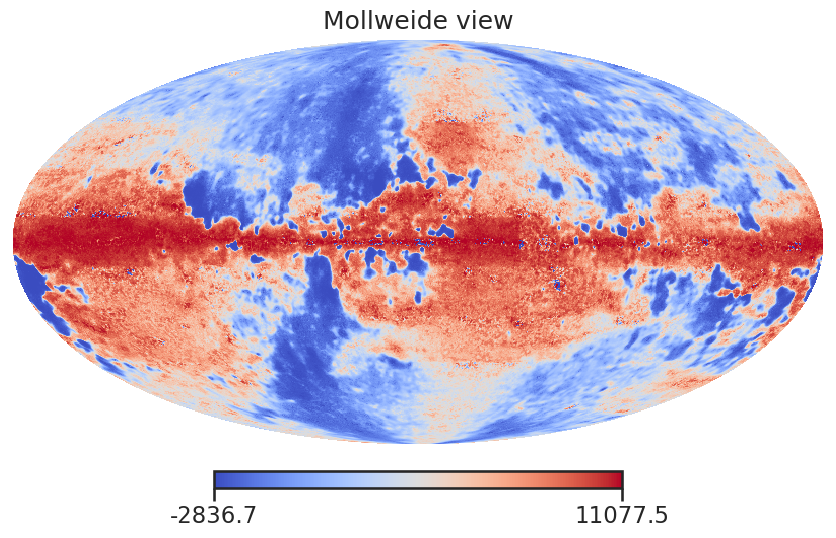

In [7]:
hp.mollview(map_forse[0][0], norm = 'hist')

In [13]:
def display_top(snapshot, key_type='lineno', limit=3):
    snapshot = snapshot.filter_traces((
        tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
        tracemalloc.Filter(False, "<unknown>"),
    ))
    top_stats = snapshot.statistics(key_type)

    print("Top %s lines" % limit)
    for index, stat in enumerate(top_stats[:limit], 1):
        frame = stat.traceback[0]
        # replace "/path/to/module/file.py" with "module/file.py"
        filename = os.sep.join(frame.filename.split(os.sep)[-2:])
        print("#%s: %s:%s: %.1f GiB"
              % (index, filename, frame.lineno, stat.size / 1024**3))
        line = linecache.getline(frame.filename, frame.lineno).strip()
        if line:
            print('    %s' % line)

    other = top_stats[limit:]
    if other:
        size = sum(stat.size for stat in other)
        print("%s other: %.1f GiB" % (len(other), size / 1024**3))
    total = sum(stat.size for stat in top_stats)
    print("Total allocated size: %.1f GiB" % (total / 1024**3))


In [14]:
snapshot = tracemalloc.take_snapshot()
display_top(snapshot)

Top 3 lines
#1: core/numeric.py:203: 13.3 GiB
    a = empty(shape, dtype, order)
#2: lib/npyio.py:448: 7.6 GiB
    return pickle.load(fid, **pickle_kwargs)
#3: framework/ops.py:1095: 6.6 GiB
    return maybe_arr.copy() if isinstance(maybe_arr, np.ndarray) else maybe_arr
3972 other: 15.6 GiB
Total allocated size: 43.0 GiB


In [10]:
sys.getsizeof(model_Q_3)

48

In [4]:
psutil.Process().memory_info().rss / (1024 * 1024)

12482.38671875

In [7]:
sys.getsizeof(ori_train_Q) / (1024 * 1024)

0.00012969970703125

In [14]:
sys.getsizeof(Ls_Q80amin)/(1024**2)

135.93762969970703

In [11]:
174*320*320*64/8/1024/1024

135.9375

In [6]:
sys.getsizeof(maps_3amin)

120

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


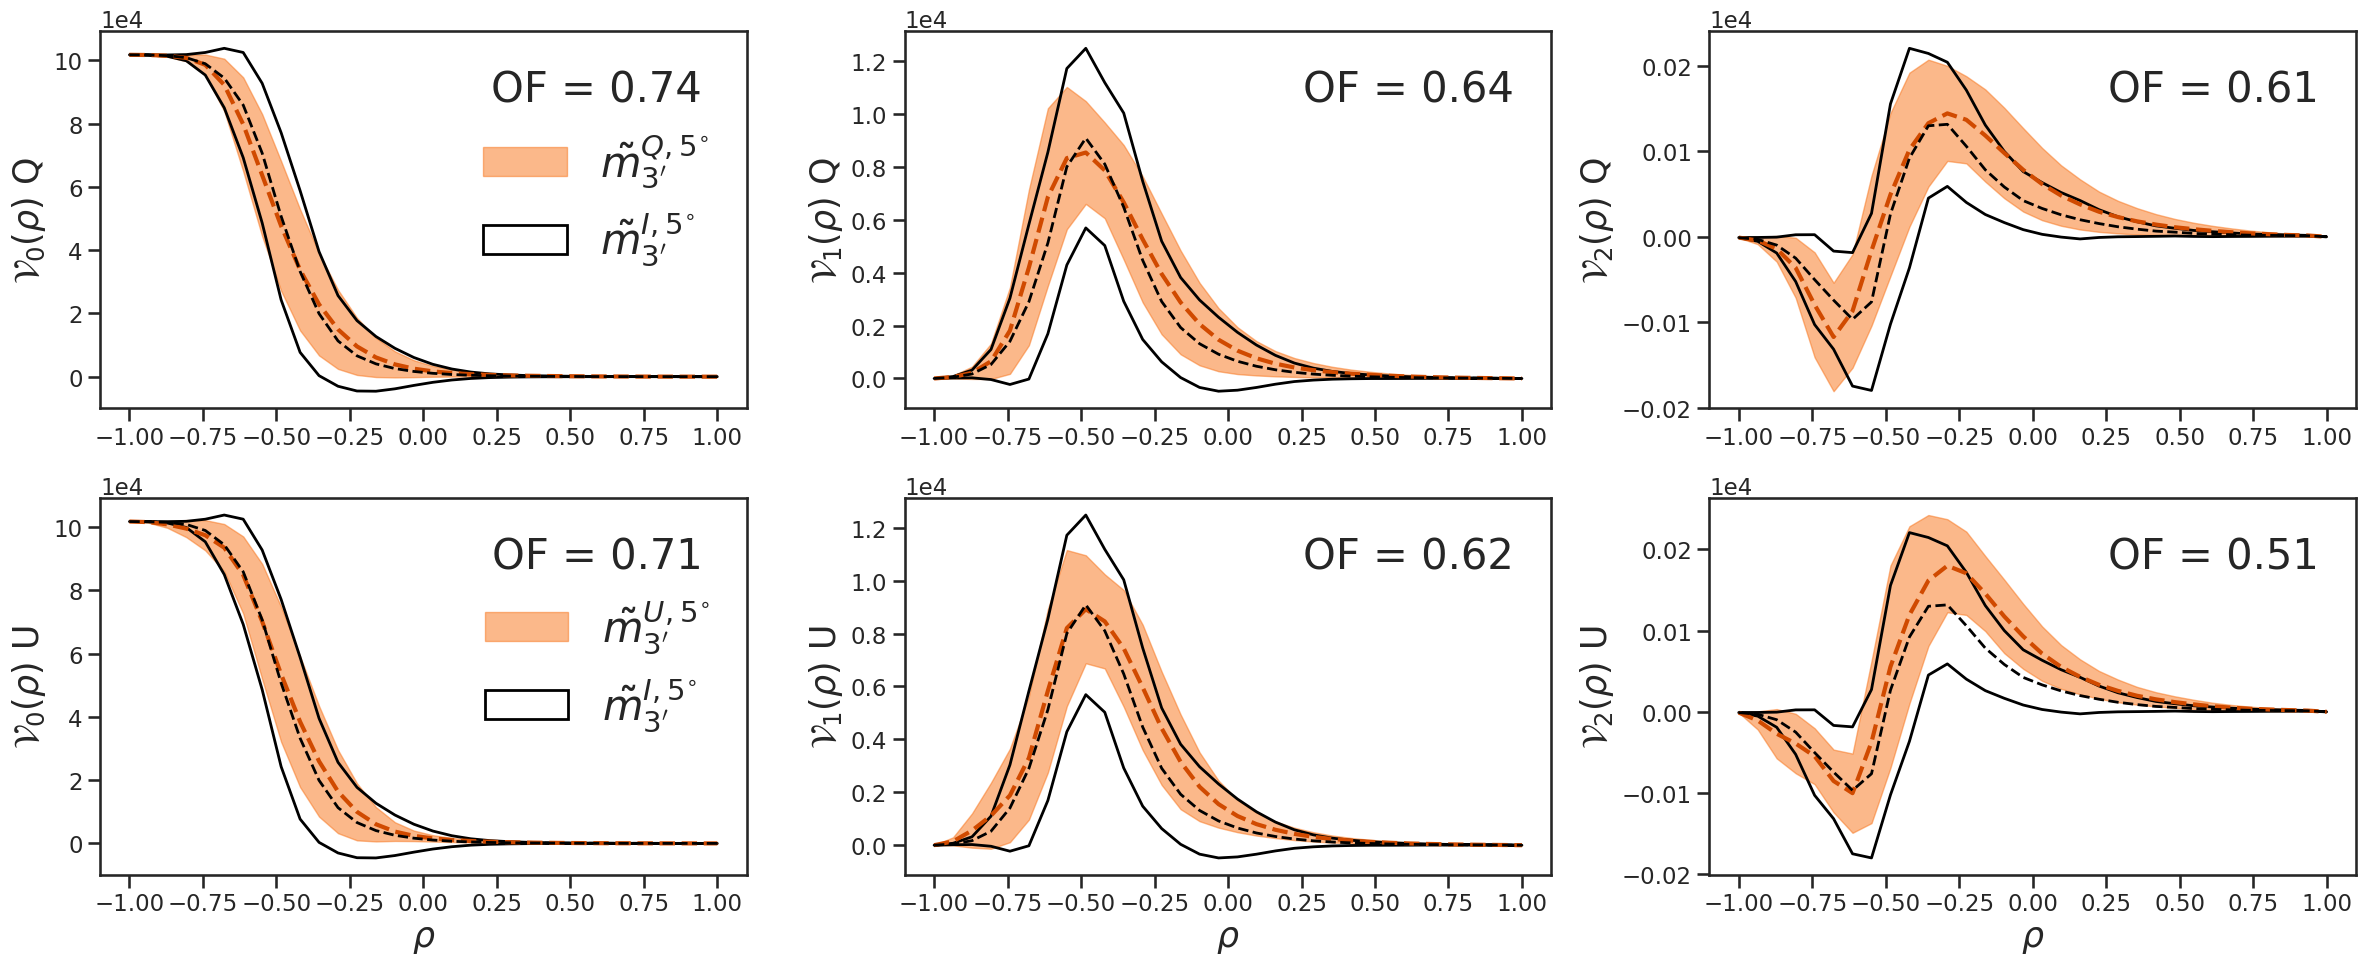

In [6]:
test = output3.plot_MF(patch_N = 5, savedir=False)